In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import faiss
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2
from attention_unet import Attention_block, conv_block, up_conv
import matplotlib.pyplot as plt
from dataloaders import OneImageDataset

In [2]:
import albumentations as A

In [3]:
dataset_path = Path('/home/e_radionova/Datasets/Caltech_birds/CUB_200_2011/dataset/train')
# dataset_path = Path('/home/e_radionova/Datasets/SimpleShapes_10_classes/dataset')

### 1. Create dataset

In [4]:
transform = A.Compose([
    A.CenterCrop(width=400, height=288),
#     A.CenterCrop(width=320, height=192),
])

In [177]:
# trans = transforms.Compose([
#     transforms.Resize((288, 400), interpolation=Image.NEAREST),
#     transforms.ToTensor(),
# ])

train_set = OneImageDataset(images_folder = dataset_path / 'images/001.Black_footed_Albatross/',
                            masks_folder = dataset_path / 'masks/001.Black_footed_Albatross/',
                            idx=9,
                            img_transform=transform)


# train_set = OneImageDataset(images_folder = dataset_path / 'images/',
#                             masks_folder = dataset_path / 'masks/',
#                             idx=820,
#                             img_transform=transform)

In [178]:
# from torchvision.transforms import ToTensor

# item_mask = cv2.imread(str(dataset_path / 'masks/001.Black_footed_Albatross/' / \
#                            'Black_Footed_Albatross_0017_796098.png'))
# transformed = transform(image=new_image, mask=item_mask)
# item_image = transformed['image']
# to_tensor = ToTensor()
# item_image = to_tensor(item_image.copy())

In [179]:
# item_image = torch.unsqueeze(item_image, 0)
# print(item_image.shape)
# plt.imshow(item_image[0].permute(1,2,0))

Text(0.5, 1.0, 'Black_Footed_Albatross_0036_796127.jpg')

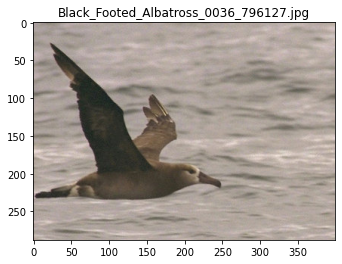

In [180]:
batch_size=1
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
}

inputs = next(iter(dataloaders['train']))

# dataloaders['train'].dataset.images_names

plt.imshow(inputs[0].permute(1,2,0))
plt.title(dataloaders['train'].dataset.images_names[0])

### 2. Create and run model

In [181]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [182]:
from test_model import TestModel

in_channels = 3
model = TestModel(in_channels)
output = model(inputs)

In [183]:
# imgs_count = output.shape[1]
# fig, ax = plt.subplots(imgs_count//4, 4, figsize=(20, 100))
# for i in range(imgs_count):
#     ax[i//4, i%4].imshow(output.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
#     ax[i//4, i%4].set_title(f'Layer {i}')

### 3. Choose feature map

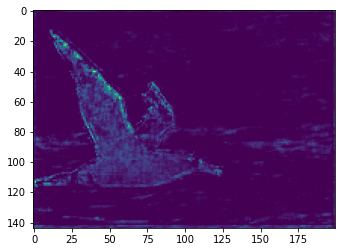

In [184]:
i=50
fm = output.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0)
plt.imshow(fm)

### 4. Get template by thresholding

(144, 200, 1)
avg: 0.49055284
max: 5.618153


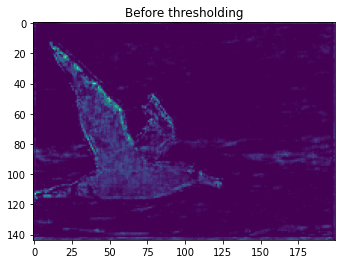

avg: 2.8090765
max: 5.618153


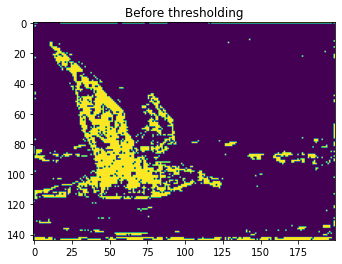

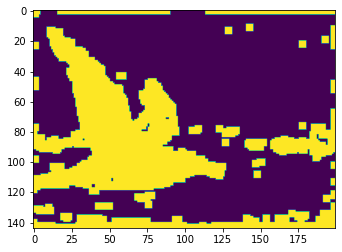

In [185]:
from template_matching_funcs import thresholding

print(fm.shape)
fm_thresh = thresholding(fm, 1.0)
fm_thresh = thresholding(fm_thresh, 1.0, otsu=True)
kern = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
fm_thresh = cv2.morphologyEx(fm_thresh, cv2.MORPH_CLOSE, kern)
fm_thresh = cv2.dilate(fm_thresh,kern,iterations = 1)
plt.imshow(fm_thresh)

#### Template matching example 

In [186]:
from template_matching_funcs import template_matching

img = cv2.imread(str(dataset_path / 'images/001.Black_footed_Albatross/' / dataloaders['train'].dataset.images_names[0]))
result_matchimg = template_matching(img, 
                                    fm_thresh)

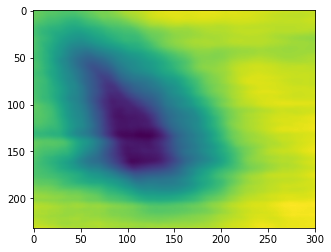

In [187]:
plt.imshow(result_matchimg)

### 5. To get kernel

In [188]:
from template_matching_funcs import template_matching, thresholding, get_Fourier_coeffs_and_kernel

def get_kernel_baseline(image, template, order, kernel_size,
                       morph_open, morph_close, dilate):
#     img_match = template_matching(image=image, template=template, method=cv2.TM_CCORR)
    img_thresh = thresholding(template, 1.0, otsu=True)
    
#     r = cv2.selectROI(img_thresh)
#     imCrop = img_thresh[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
#     plt.imshow(imCrop)
#     plt.show()
    
    kern = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))  # np.ones((5,5),np.uint8)
    if morph_open:
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kern)
    if morph_close:
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kern)
    if dilate:
        img_thresh = cv2.dilate(img_thresh,kern,iterations = 1)
    
    img_thresh = 255 * abs(img_thresh / img_thresh.max())
#     img_thresh = np.array(img_thresh, np.uint8)
    print(np.unique(img_thresh))
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Image after thresholfing')
    plt.show()
    _, kernel = get_Fourier_coeffs_and_kernel(img_thresh, order=order, kernel_size=kernel_size)
    
    return kernel, img_thresh

avg: 3.0
max: 6


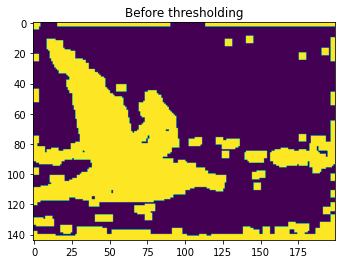

[  0. 255.]


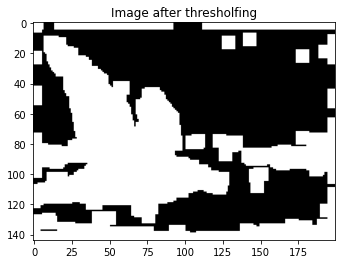

In [189]:
kernel_per_img, img_thresh = get_kernel_baseline(image=img, 
                                                 template=fm_thresh, 
                                                 order=10, 
                                                 kernel_size=20,
                                                 morph_open=False, 
                                                 morph_close=False, 
                                                 dilate=True)

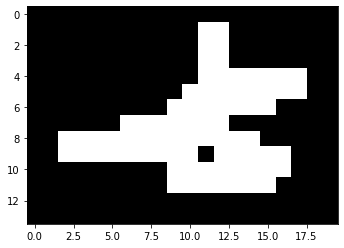

In [190]:
plt.imshow(kernel_per_img)

In [191]:
np.unique(kernel_per_img)

array([0., 1.])

### Pre-trained detection

In [192]:
import sys
sys.path.insert(1, '/home/e_radionova/a-PyTorch-Tutorial-to-Object-Detection')

In [193]:
from detect import detect

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [200]:
path = str(dataset_path / 'images/001.Black_footed_Albatross/' / dataloaders['train'].dataset.images_names[0])
# path = str(dataset_path / 'images/' / dataloaders['train'].dataset.images_names[0])
detect_img = Image.open(path).convert('RGB')

In [202]:
im = Image.fromarray(img_thresh).convert('RGB')

In [204]:
# detect(original_image=im, min_score=0.2, max_overlap=0.5, top_k=200)
image, box_coords = detect(original_image=detect_img, min_score=0.2, max_overlap=0.5, top_k=200)

[44.327781677246094, 75.20275115966797, 312.5919189453125, 280.49908447265625]


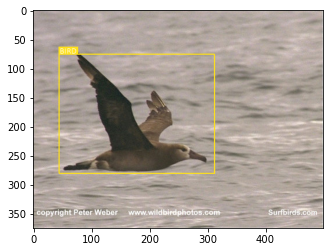

In [197]:
plt.imshow(image)

In [198]:
box_coords = [int(point) for point in box_coords] 
x1, y1, x2, y2 = box_coords

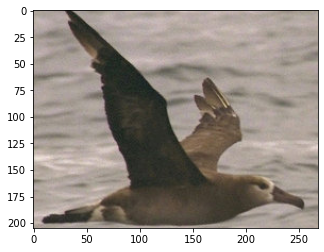

In [201]:
plt.imshow(np.array(detect_img)[y1:y2, x1:x2, :])